##### Follow similar pattern just as the signle dense layer network (one node), Which essentially models linear regression. Here, we use network of 3 dense layers and learn to optimize the learning rate parameter using callbacks.  
  

In [1]:
!pip3 install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 113kB/s 
     |████████████████████████████████| 501kB 51.2MB/s 
     |████████████████████████████████| 3.1MB 40.9MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print ("check tfversion: ", tf.__version__)

check tfversion:  2.0.0-beta0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize = 12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True)

In [0]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
# series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.07
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1100

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=2)

Epoch 1/100
34/34 - 0s - loss: 999.5842
Epoch 2/100
34/34 - 0s - loss: 75.2889
Epoch 3/100
34/34 - 0s - loss: 64.4224
Epoch 4/100
34/34 - 0s - loss: 61.0826
Epoch 5/100
34/34 - 0s - loss: 59.6270
Epoch 6/100
34/34 - 0s - loss: 58.3029
Epoch 7/100
34/34 - 0s - loss: 57.2058
Epoch 8/100
34/34 - 0s - loss: 56.2946
Epoch 9/100
34/34 - 0s - loss: 55.5279
Epoch 10/100
34/34 - 0s - loss: 54.8960
Epoch 11/100
34/34 - 0s - loss: 54.3682
Epoch 12/100
34/34 - 0s - loss: 53.9209
Epoch 13/100
34/34 - 0s - loss: 53.5373
Epoch 14/100
34/34 - 0s - loss: 53.2013
Epoch 15/100
34/34 - 0s - loss: 52.9049
Epoch 16/100
34/34 - 0s - loss: 52.6425
Epoch 17/100
34/34 - 0s - loss: 52.4035
Epoch 18/100
34/34 - 0s - loss: 52.1845
Epoch 19/100
34/34 - 0s - loss: 51.9810
Epoch 20/100
34/34 - 0s - loss: 51.7887
Epoch 21/100
34/34 - 0s - loss: 51.6070
Epoch 22/100
34/34 - 0s - loss: 51.4345
Epoch 23/100
34/34 - 0s - loss: 51.2707
Epoch 24/100
34/34 - 0s - loss: 51.1119
Epoch 25/100
34/34 - 0s - loss: 50.9589
Epoch 26

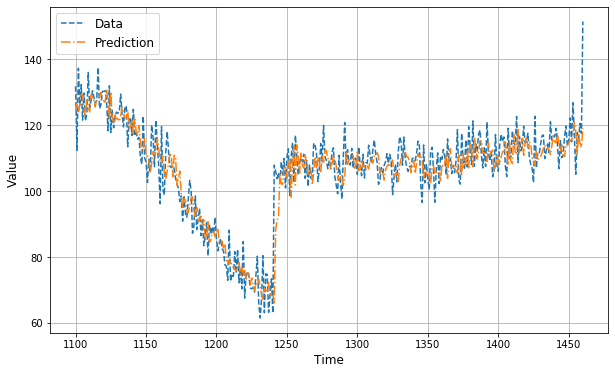

In [9]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid, '--')
plot_series(time_valid, results, '-.')
labels = ['Data', 'Prediction']
plt.legend(labels, fontsize=12)
plt.show()

In [10]:
# Mean Absolute Error 

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.937663

### Learn to Determine the Best Learning Rate Using Callbacks 

As in keras documentation _A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training_. 

Here we will use the _LearningRateScheduler_ where the input argument is 
_schedule: a function that takes an epoch index as input (integer, indexed from 0) and current learning rate and returns a new learning rate as output (float)._ 

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=80, callbacks=[lr_schedule], verbose=2)

Epoch 1/80
34/34 - 0s - loss: 2728.5851
Epoch 2/80
34/34 - 0s - loss: 363.0154
Epoch 3/80
34/34 - 0s - loss: 278.9155
Epoch 4/80
34/34 - 0s - loss: 275.7316
Epoch 5/80
34/34 - 0s - loss: 273.1103
Epoch 6/80
34/34 - 0s - loss: 270.4117
Epoch 7/80
34/34 - 0s - loss: 267.5283
Epoch 8/80
34/34 - 0s - loss: 264.4397
Epoch 9/80
34/34 - 0s - loss: 261.1764
Epoch 10/80
34/34 - 0s - loss: 257.7105
Epoch 11/80
34/34 - 0s - loss: 253.9784
Epoch 12/80
34/34 - 0s - loss: 249.9772
Epoch 13/80
34/34 - 0s - loss: 245.7577
Epoch 14/80
34/34 - 0s - loss: 241.3295
Epoch 15/80
34/34 - 0s - loss: 236.6271
Epoch 16/80
34/34 - 0s - loss: 231.6655
Epoch 17/80
34/34 - 0s - loss: 226.4012
Epoch 18/80
34/34 - 0s - loss: 220.8490
Epoch 19/80
34/34 - 0s - loss: 215.0242
Epoch 20/80
34/34 - 0s - loss: 208.9192
Epoch 21/80
34/34 - 0s - loss: 202.5625
Epoch 22/80
34/34 - 0s - loss: 195.9698
Epoch 23/80
34/34 - 0s - loss: 189.1745
Epoch 24/80
34/34 - 0s - loss: 182.2117
Epoch 25/80
34/34 - 0s - loss: 175.1459
Epoch 26

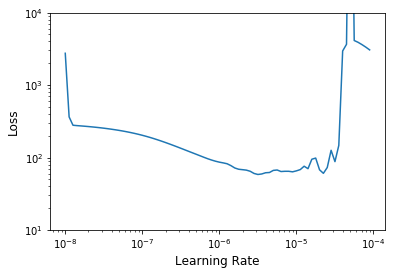

In [19]:
lrs = 1e-8 * (10 ** (np.arange(80) / 20))
plt.xscale('log')
plt.yscale('log')
plt.ylim(10, 1e4)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Learning Rate', fontsize=12)
plt.plot(lrs, history.history["loss"])
plt.show()

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)


history = model.fit(dataset, epochs=500, verbose=0)

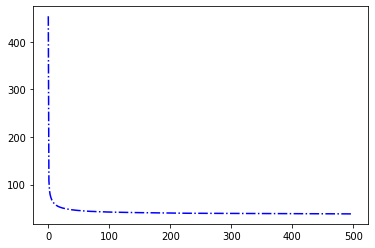

In [30]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, linestyle='-.', color='blue', label='Training Loss')
plt.show()

##### From the plot it may seem like it is completely irrelevant to use 500 epochs but let's see 

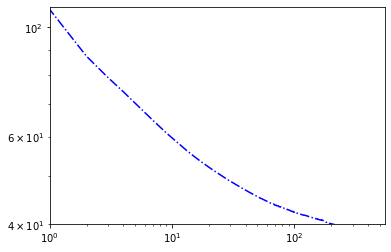

In [31]:
loss = history.history['loss']
epochs = range(len(loss))
plt.yscale('log')
plt.xscale('log')
plt.ylim(40, 110)
plt.xlim(1, 550)
plt.plot(epochs, loss, linestyle='-.', color='blue', label='Training Loss')
plt.show()

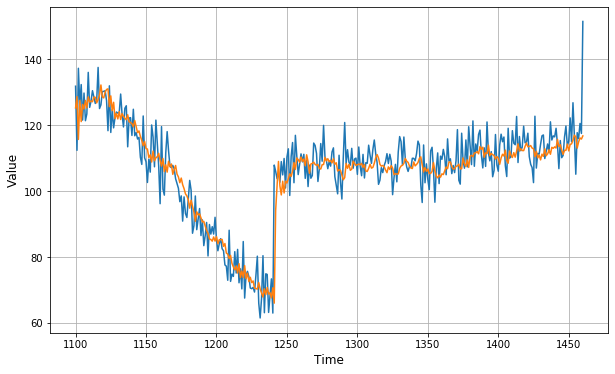

In [32]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7036476